In [20]:
import torch.optim as optim
import random

from fastai.text import *
from fastai import *
from fastai.callbacks import *
from transformers import AdamW

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

In [2]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [3]:
seed = 42
use_fp16 = False
bs = 16

model_type = 'bert'
pretrained_model_name = 'bert-base-multilingual-cased'
pretrained_model_path = 'model/bert4vn/pytorch_model.bin'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [4]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [5]:
path = Path('.')
train = pd.read_csv(path/'medical_data/title/train.csv', sep='\t')
test = pd.read_csv(path/'medical_data/title/test.csv', sep='\t')

In [6]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [7]:
seed_all(seed)

In [8]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper PretrainedTokenizer with tokenizer of fastai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type='bert'):
        super(TransformersBaseTokenizer, self).__init__(lang='')
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type
        
    def __call__(self, *args, **kwargs):
        return self
    
    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add special tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] + [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [9]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer=transformer_tokenizer, model_type=model_type)
fastai_tokenizer = Tokenizer(tok_func=transformer_base_tokenizer, pre_rules=[], post_rules=[])


In [10]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos=[])
        self.tokenizer = tokenizer
        
    def numericalize(self, t:Collection[str]) -> List[int]:
        """Convert a list of tokens 't' to their ids"""
        return self.tokenizer.convert_tokens_to_ids(t)
    
    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        """Convert a list of numbers to their tokens"""
        nums = np.array(nums).tolist()
        return (
            sep.join(self.tokenizer.convert_ids_to_tokens(nums)) 
            if sep is not None 
            else self.tokenizer.convert_ids_to_tokens(nums)
        )
    
    def __getstate__(self):
        return {'itos': self.itos, 'tokenizer': self.tokenizer}
    
    def __setstate__(self, state: dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int, {v: k for k, v in enumerate(self.itos)})

In [11]:
transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [12]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [13]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1, seed=seed)
             .label_from_df(cols='label')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [14]:
print("[CLS] token: ", transformer_tokenizer.cls_token)
print("[SEP] token: ", transformer_tokenizer.sep_token)
print("[PAD] token: ", transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token:  <s>
[SEP] token:  </s>
[PAD] token:  <pad>


text,target
"<s> Ġ- L RB - ĠCity Ġ- RR B - Ġreminds Ġus Ġhow Ġrealistically Ġnuanced Ġa ĠRobert ĠDe ĠN iro Ġperformance Ġcan Ġbe Ġwhen Ġhe Ġis Ġnot Ġmore Ġluc r atively Ġengaged Ġin Ġthe Ġshameless Ġself - car ic ature Ġof Ġ` ĠAnaly ze ĠThis Ġ' Ġ- L RB - Ġ1999 Ġ- RR B - Ġand Ġ` ĠAnaly ze ĠThat Ġ, Ġ' Ġpromised Ġ- L RB - Ġor Ġthreatened Ġ-",3
"<s> ĠThe Ġreal Ġtriumph s Ġin ĠIg by Ġcome Ġfrom ĠPhilippe Ġ, Ġwho Ġmakes ĠOliver Ġfar Ġmore Ġinteresting Ġthan Ġthe Ġcharacter Ġ' s Ġlines Ġwould Ġsuggest Ġ, Ġand ĠSar andon Ġ, Ġwho Ġcould Ġn 't Ġbe Ġbetter Ġas Ġa Ġcruel Ġbut Ġweird ly Ġlik able ĠWAS P Ġmat ron Ġ. </s>",3
"<s> ĠParker Ġshould Ġbe Ġcomm ended Ġfor Ġtaking Ġa Ġfresh Ġapproach Ġto Ġfamiliar Ġmaterial Ġ, Ġbut Ġhis Ġdetermination Ġto Ġremain Ġtrue Ġto Ġthe Ġoriginal Ġtext Ġleads Ġhim Ġto Ġadopt Ġa Ġsomewhat Ġman nered Ġtone Ġ... Ġthat Ġultimately Ġdull s Ġthe Ġhuman Ġtragedy Ġat Ġthe Ġstory Ġ' s Ġcore </s>",2
"<s> ĠIt Ġ' s Ġa Ġlong Ġway Ġfrom ĠOrwell Ġ' s Ġdark Ġ, Ġintelligent Ġwarning Ġcry Ġ- L RB - Ġ1984 Ġ- RR B - Ġto Ġthe Ġempty Ġstud Ġknock about Ġof ĠEqu ilibrium Ġ, Ġand Ġwhat Ġonce Ġwas Ġconviction Ġis Ġnow Ġaffect ation Ġ. </s>",1
"<s> ĠA Ġdifferent Ġand Ġemotionally Ġreserved Ġtype Ġof Ġsurvival Ġstory Ġ-- Ġa Ġfilm Ġless Ġabout Ġref ract ing Ġall Ġof ĠWorld ĠWar ĠII Ġthrough Ġthe Ġspecific Ġconditions Ġof Ġone Ġman Ġ, Ġand Ġmore Ġabout Ġthat Ġman Ġlost Ġin Ġits Ġmidst Ġ. </s>",3


In [15]:
print("[CLS] id: ", transformer_tokenizer.cls_token_id)
print("[SEP] id: ", transformer_tokenizer.sep_token_id)
print("[PAD] id: ", pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape: ', test_one_batch.shape)
print(test_one_batch)

[CLS] id:  0
[SEP] id:  2
[PAD] id:  1
Batch shape:  torch.Size([16, 79])
tensor([[    0,   111,   574,  ...,    76,   479,     2],
        [    0,    33,     7,  ...,     1,     1,     1],
        [    0,   318,    47,  ...,     1,     1,     1],
        ...,
        [    0,     5,  2156,  ...,     1,     1,     1],
        [    0,    33, 30291,  ...,     1,     1,     1],
        [    0, 45518, 10730,  ...,     1,     1,     1]])


In [16]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel, self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids != pad_idx).type(input_ids.type())
        logits = self.transformer(input_ids, attention_mask=attention_mask)[0]
        return logits

In [17]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)

RobertaConfig {
  "_num_labels": 5,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "min_length": 0,
  "model_type": "roberta",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states"

In [18]:
transfromer_model = model_class.from_pretrained(pretrained_model_name_or_path=path/'model/roberta-base/pytorch_model.bin', config=config)
custom_transformer_model = CustomTransformerModel(transformer_model=transfromer_model)

In [21]:
CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(
    databunch,
    custom_transformer_model,
    opt_func=CustomAdamW,
    metrics=[accuracy, error_rate]
)

learner.callbacks.append(ShowGraph(learner))

if use_fp16:
    learner = learner.to_fp16()

In [22]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

In [23]:
list_layers = [
    learner.model.transformer.roberta.embeddings,
    learner.model.transformer.roberta.encoder.layer[0],
    learner.model.transformer.roberta.encoder.layer[1],
    learner.model.transformer.roberta.encoder.layer[2],
    learner.model.transformer.roberta.encoder.layer[3],
    learner.model.transformer.roberta.encoder.layer[4],
    learner.model.transformer.roberta.encoder.layer[5],
    learner.model.transformer.roberta.encoder.layer[6],
    learner.model.transformer.roberta.encoder.layer[7],
    learner.model.transformer.roberta.encoder.layer[8],
    learner.model.transformer.roberta.encoder.layer[9],
    learner.model.transformer.roberta.encoder.layer[10],
    learner.model.transformer.roberta.encoder.layer[11],
    learner.model.transformer.roberta.pooler,
]

In [24]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in', num_groups, ' groups')
print(learner.layer_groups)

Learner split in 14  groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2

In [25]:
learner.save('untrain')

In [26]:
seed_all(seed)
learner.load('untrain')

Learner(data=TextClasDataBunch;

Train: LabelList (140454 items)
x: TextList
<s> ĠA Ġseries Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>,<s> ĠA Ġseries </s>,<s> ĠA </s>,<s> Ġseries </s>,<s> Ġof Ġesc ap ades Ġdemonstrating Ġthe Ġad age Ġthat Ġwhat Ġis Ġgood Ġfor Ġthe Ġgoose </s>
y: CategoryList
2,2,2,2,2
Path: .;

Valid: LabelList (15606 items)
x: TextList
<s> Ġ' s Ġas Ġsorry </s>,<s> ĠRomantic Ġcomedy Ġand ĠDog me Ġ95 Ġfilmmaking Ġmay Ġseem Ġodd Ġbed fell ows Ġ, Ġbut Ġthey Ġturn Ġout Ġto Ġbe Ġdelight fully Ġcompatible Ġhere </s>,<s> Ġof Ġthese Ġdays </s>,<s> Ġfl inch Ġfrom Ġits Ġunsettling Ġprog nosis </s>,<s> Ġare Ġclinically Ġdepressed </s>
y: CategoryList
2,4,2,2,1
Path: .;

Test: LabelList (66292 items)
x: TextList
<s> Ġ15 60 61 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort Ġ. </s>,<s> Ġ15 60 62 Ġ85 45 ĠAn Ġintermitt ently Ġpleasing Ġbut Ġmostly Ġroutine Ġeffort </s>,<s> Ġ15 60 63 Ġ85 45 ĠAn </s>,<s> Ġ15 60 64 Ġ85 45

In [27]:
learner.freeze_to(-1)

In [28]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [79, 768]            38,603,520 False     
______________________________________________________________________
Embedding            [79, 768]            394,752    False     
______________________________________________________________________
Embedding            [79, 768]            768        False     
______________________________________________________________________
LayerNorm            [79, 768]            1,536      False     
______________________________________________________________________
Dropout              [79, 768]            0          False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
_______________________________________

In [29]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 1.91E-05


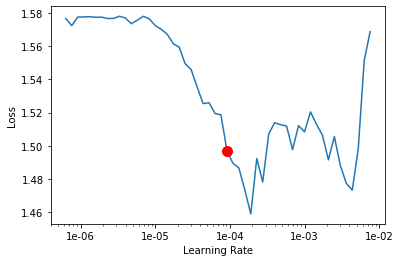

In [31]:
learner.recorder.plot(skip_end=10, suggestion=True)

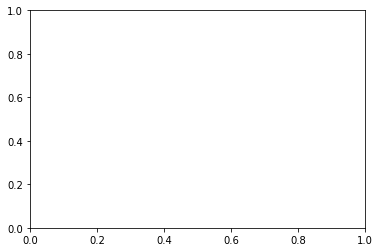

In [32]:
learner.fit_one_cycle(1, max_lr=8e-5, moms=(0.8, 0.7))

In [33]:
learner.save('first_cycle')

In [ ]:
seed_all(seed)
learner.load('first_cycle')

In [ ]:
learner.freeze_to(-2)

In [ ]:
lr = 1e-5

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('second_cycle')

In [ ]:
seed_all(seed)
learner.load('second_cycle')

In [ ]:
learner.freeze_to(-3)

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('third_cycle')

In [ ]:
seed_all(seed)
learner.load('third_cycle')

In [ ]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.predict('This is the best movie of 2020')

In [ ]:
learner.predict('This is the worst movie of 2020')

In [ ]:
learner.export(file = 'transformer.pkl')

In [ ]:
export_learner = load_learner(path, file = 'transformer.pkl')

In [ ]:
export_learner.predict('This is the worst movie of 2020')

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [ ]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
sample_submission = pd.read_csv(path / 'sampleSubmission.csv')
sample_submission['Sentiment'] = np.argmax(test_preds,axis=1)
sample_submission.to_csv("predictions.csv", index=False)

In [ ]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='predictions.csv')
